In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np
import os
import glob
from desisim.quickcat import quickcat
import fitsio
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask, targetid_mask, obsconditions

%matplotlib inline

In [2]:
program = 'dark'
main_path = "/global/cscratch1/sd/forero/elgsplitrandom/"

In [3]:
truth = Table.read(os.path.join(main_path, 'targets', program, 'truth.fits'))
mtl = Table.read(os.path.join(main_path, 'zcat', program, '0', 'mtl.fits'))
zcat = Table.read(os.path.join(main_path, 'zcat', program, '16','zcat.fits'))

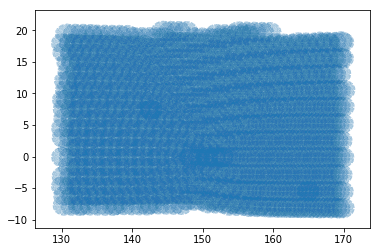

In [4]:
inz = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.scatter(mtl['RA'][inz], mtl['DEC'][inz], s=1E-4)

In [5]:
expfile = os.path.join(main_path, 'survey','exposures_dark_baseline_1m.fits')
explist = Table.read(expfile)

dark_tiles = list(set(explist['TILEID'][explist['PROGRAM']=='DARK']))
gray_tiles = list(set(explist['TILEID'][explist['PROGRAM']=='GRAY']))
print(len(dark_tiles))
print(len(gray_tiles))

637
158


In [6]:
tilefiles = glob.glob(main_path+"/zcat/dark/*/fiberassign/tile*.fits")
graytilefiles = []
for i in range(len(gray_tiles)):
    tilestring = '{:05d}'.format(gray_tiles[i])
    for tilefile in tilefiles:
        if tilefile.find(tilestring)>0:
            #print(tilefile, tilestring)
            graytilefiles.append(tilefile)
            
darktilefiles = []
for i in range(len(dark_tiles)):
    tilestring = '{:05d}'.format(dark_tiles[i])
    for tilefile in tilefiles:
        if tilefile.find(tilestring)>0:
            #print(tilefile, tilestring)
            darktilefiles.append(tilefile)

In [7]:
def tile_efficiency(alltilefiles, target_type):
    n_tiles = len(alltilefiles)
    galaxies = np.ones(n_tiles)
    unused = np.ones(n_tiles)
    print(n_tiles)
    result = {}
    for i in range(n_tiles):
        tilefile = alltilefiles[i]
        obstargets = Table.read(tilefile, hdu=1)
        unused[i] = np.count_nonzero(obstargets['TARGETID']==-1)
    result['UNUSED'] = unused
    
    for t in target_type:
        for i in range(n_tiles):
            tilefile = alltilefiles[i]
            obstargets = Table.read(tilefile, hdu=1)
            galaxies[i] = np.count_nonzero((obstargets['DESI_TARGET']&desi_mask.mask(t))!=0)
        result[t] = galaxies.copy()
        
    return result

In [8]:
def zcat_efficiency(zcat_table, mtl_table, table_truth, target_type):
    in_square = (mtl_table['RA']>130) &\
        (mtl_table['RA']<169) &\
        (mtl_table['DEC']<17) &\
        (mtl_table['DEC']>-7)
    tmp_mtl = mtl_table[in_square]
    
    in_square = np.in1d(zcat_table['TARGETID'], tmp_mtl['TARGETID'])
    tmp_zcat = zcat_table[in_square]
    result = {}
    #tmp_table = mtl_table[inz]
    for t in target_type:
        n_in = np.count_nonzero((tmp_mtl['DESI_TARGET']&desi_mask.mask(t))!=0)
        ii = np.in1d(tmp_mtl['TARGETID'], tmp_zcat['TARGETID'])
        n_out = np.count_nonzero((tmp_mtl['DESI_TARGET'][ii]&desi_mask.mask(t))!=0)
        result[t] = {'n_in':n_in, 'n_out':n_out}
    return result

In [9]:
n_global = zcat_efficiency(zcat, mtl, truth, ['DELG','ELG', 'LRG', 'QSO'])

In [10]:
def print_zcat_eff(n_global, galtype):
    n_in = n_global[galtype]['n_in']
    n_out =  n_global[galtype]['n_out']
    eff = n_out/n_in
    print("{}\t {:d}k\t {:d}k \t {:.2f}".format(galtype, int(n_in/1E3), int(n_out/1E3), eff))

print_zcat_eff(n_global, 'DELG')
print_zcat_eff(n_global, 'LRG')
print_zcat_eff(n_global, 'ELG')
print_zcat_eff(n_global, 'QSO')

DELG	 737k	 675k 	 0.91
LRG	 317k	 312k 	 0.99
ELG	 1754k	 1299k 	 0.74
QSO	 121k	 121k 	 1.00


In [11]:
n_tile_dark = tile_efficiency(darktilefiles, ['DELG','ELG', 'LRG', 'QSO'])
n_tile_gray = tile_efficiency(graytilefiles, ['DELG','ELG', 'LRG', 'QSO'])
n_tile_all = tile_efficiency(tilefiles, ['DELG', 'ELG', 'LRG', 'QSO'])

639
158
797


In [12]:
print("unused fibers")
unused = n_tile_dark['UNUSED'].sum()
print("DARK {:.1f}k total. {:.1f} per tile".format(unused/1E3, unused/len(n_tile_dark['UNUSED'])))
unused = n_tile_gray['UNUSED'].sum()
print("GRAY {:.1f}k total. {:.1f} per tile".format(unused/1E3, unused/len(n_tile_gray['UNUSED'])))
unused = n_tile_all['UNUSED'].sum()
print("ALL {:.1f}k total. {:.1f} per tile".format(unused/1E3, unused/len(n_tile_all['UNUSED'])))


unused fibers
DARK 44.7k total. 69.9 per tile
GRAY 6.1k total. 38.7 per tile
ALL 50.8k total. 63.8 per tile


In [13]:
grayzcat = quickcat(graytilefiles, mtl, truth, perfect=True)

Thu Dec  7 10:43:54 2017 QC Reading 158 tiles
Thu Dec  7 10:43:56 2017 QC Trimming truth to just observed targets
Thu Dec  7 10:43:58 2017 QC Constructing new redshift catalog
Thu Dec  7 10:43:58 2017 QC Adding ZERR and ZWARN
Thu Dec  7 10:43:58 2017 QC Adding NUMOBS column
Thu Dec  7 10:44:04 2017 QC Merging previous zcat
Thu Dec  7 10:44:04 2017 QC done


In [14]:
darkzcat = quickcat(darktilefiles, mtl, truth, perfect=True)

Thu Dec  7 10:44:04 2017 QC Reading 639 tiles
Thu Dec  7 10:44:11 2017 QC Trimming truth to just observed targets
Thu Dec  7 10:44:14 2017 QC Constructing new redshift catalog
Thu Dec  7 10:44:15 2017 QC Adding ZERR and ZWARN
Thu Dec  7 10:44:15 2017 QC Adding NUMOBS column
Thu Dec  7 10:44:35 2017 QC Merging previous zcat
Thu Dec  7 10:44:35 2017 QC done


In [15]:
allzcat = quickcat(tilefiles, mtl, truth, perfect=True)

Thu Dec  7 10:44:35 2017 QC Reading 797 tiles
Thu Dec  7 10:44:45 2017 QC Trimming truth to just observed targets
Thu Dec  7 10:44:48 2017 QC Constructing new redshift catalog
Thu Dec  7 10:44:48 2017 QC Adding ZERR and ZWARN
Thu Dec  7 10:44:48 2017 QC Adding NUMOBS column
Thu Dec  7 10:45:15 2017 QC Merging previous zcat
Thu Dec  7 10:45:15 2017 QC done


In [16]:
def get_small_truth(truth_table, zcat_table, mtl_table):
    print('initializing small truth')
    small_truth = join(truth_table[['TARGETID','TEMPLATETYPE']], 
                       zcat_table['TARGETID', 'NUMOBS'], keys='TARGETID', join_type='outer')
    unobs  = small_truth['NUMOBS'].mask
    small_truth['NUMOBS'][unobs] = 0
    print('second join')
    small_truth = join(small_truth, mtl_table[['TARGETID', 'RA', 'DEC']], keys='TARGETID')
    return small_truth


In [17]:
def count_unused(tilefiles):
    unassigned = np.zeros(len(tilefiles))
    for i, filename in enumerate(tilefiles):
        fa = fitsio.read(filename, 'FIBER_ASSIGNMENTS', columns=['TARGETID',])
        unassigned[i] = np.count_nonzero(fa['TARGETID'] == -1)
    return unassigned

In [18]:
unused_all = count_unused(tilefiles)
unused_dark = count_unused(darktilefiles)
unused_gray = count_unused(graytilefiles)

In [23]:
small_truth_all = get_small_truth(truth, allzcat, mtl)
small_truth_dark = get_small_truth(truth, darkzcat, mtl)
small_truth_gray = get_small_truth(truth, grayzcat, mtl)
small_truth = get_small_truth(truth, zcat, mtl)

initializing small truth


second join


initializing small truth
second join
initializing small truth
second join
initializing small truth
second join


In [24]:
def print_eff(table_truth):
    name = {'DELG':'DELG      ', 'ELG':'ELG       ', 'QSO':'QSO       ', 'LRG':'LRG       ', 
           'SKY':'SKY       ', 'STAR':'STAR      '}
    in_square = (table_truth['RA']>130) &\
        (table_truth['RA']<169) &\
        (table_truth['DEC']<17) &\
        (table_truth['DEC']>-7)
    
    tmp_truth = table_truth[in_square]
    print("{}\t {}\t {}\t {}".format("Type", "In", "Out", "Out/In"))
    for k in ['DELG', 'ELG', 'LRG', 'QSO']:
        tmp_type = name[k]
        total = 1.0*np.count_nonzero( tmp_truth['TEMPLATETYPE'] == tmp_type)
        num_obs = 1.0*np.count_nonzero(tmp_truth['TEMPLATETYPE'][tmp_truth['NUMOBS']>0] == tmp_type)
        print("{}\t {:d}k\t {:d}k \t {:.2f}".format(k, int(total/1000), int(num_obs/1000), num_obs/total))

In [25]:
def print_unused(unused_fibers):
    total = 5000.0 * len(unused_fibers)
    unused = np.sum(unused_fibers)
    used = total-unused
    print("{}\t {:d}k\t {:d}k \t {:.2f}".format("Fibers", int(total/1E3), int(used/1E3), used/total))
    print("{}\t {:d}k".format("Unused Fibers", int(unused/1E3)))

In [26]:
print("DARK")
print_eff(small_truth_dark)
print_unused(unused_dark)

DARK
Type	 In	 Out	 Out/In
DELG	 737k	 675k 	 0.91
ELG	 1754k	 721k 	 0.41
LRG	 317k	 312k 	 0.99
QSO	 121k	 121k 	 1.00
Fibers	 3195k	 3150k 	 0.99
Unused Fibers	 44k


In [27]:
print("GRAY")
print_eff(small_truth_gray)
print_unused(unused_gray)

GRAY
Type	 In	 Out	 Out/In
DELG	 737k	 0k 	 0.00
ELG	 1754k	 578k 	 0.33
LRG	 317k	 0k 	 0.00
QSO	 121k	 0k 	 0.00
Fibers	 790k	 783k 	 0.99
Unused Fibers	 6k


In [28]:
print("DARK + GRAY")
print_eff(small_truth_all)
print_unused(unused_all)

DARK + GRAY
Type	 In	 Out	 Out/In
DELG	 737k	 675k 	 0.91
ELG	 1754k	 1299k 	 0.74
LRG	 317k	 312k 	 0.99
QSO	 121k	 121k 	 1.00
Fibers	 3985k	 3934k 	 0.99
Unused Fibers	 50k
